# 类型与方法
日期：2021.10.24

作者：陈久宁

大纲：

- 基本概念：覆盖一些关于类型和方法常用的基本语法
- 设计思路：在具体实践中的一些典型设计模式

更多的内容可以参考文档的以下几节内容：

- [类型](https://docs.julialang.org/en/v1/manual/types/)
- [方法](https://docs.julialang.org/en/v1/manual/methods/)
- [性能建议](https://docs.julialang.org/en/v1/manual/performance-tips/)
- [风格建议](https://docs.julialang.org/en/v1/manual/style-guide/)

In [1]:
using BenchmarkTools
using LinearAlgebra

In [2]:
my_add(x, y) = x * y
my_add(x::Number, y::Number) = x + y

my_add (generic function with 2 methods)

## 1. 基本概念

## 1.1. 类型的声明和实例化

Julia 下类型是一个简单的结构体，通过 `struct` 进行声明

In [3]:
# 定义了一个 Point2D 类型，其中有两个元素 `x`, `y` 均为 `Float64` (64位浮点数) 类型
struct Point2D <: Any
    x::Float64
    y::Float64
end

Julia 使用 `<:` 来表示一个类型是另一个类型的子集，例如在 Julia 下，所有类型都是 `Any` 的子集。

In [4]:
Point2D <: Any

true

创建一个对象所调用的函数被称为__构造函数__.
Julia 会提供一个默认的构造函数，从而允许我们通过指定全部数据的形式来构造实例：

In [5]:
p = Point2D(3.0, 4.0)

Point2D(3.0, 4.0)

实际上也允许隐式的类型转换

In [6]:
p = Point2D(3, 4) # Int -> Float64

Point2D(3.0, 4.0)

这是因为 Julia 默认情况下提供了两个构造函数

In [7]:
methods(Point2D) # methods 用来查询一个函数的不同的方法

# 2 methods for type constructor:
[1] Point2D(x::Float64, y::Float64) in Main at In[3]:3
[2] Point2D(x, y) in Main at In[3]:3

这背后完整的写法实际是

```julia
struct Point2D
    x::Float64
    y::Float64
    #内置构造函数：即放在结构体的定义内部实现的构造函数
    # 下面是 Julia 提供的默认构造函数，大多数时候使用这个默认的方法就可以了
    function Point2D(x::Float64, y::Float64)
        # new 是一个只在内置构造函数里可以使用的函数，大概意思是这个类型实例的构造到此为止完成了
        new(x, y)
    end
    # 构造函数也是函数，所以也可以使用单行定义的形式
    Point2D(x, y) = Point2D(Float64(x), Float64(y))
end
```

更多的时候，如果需要更多的构造方式的话，是直接提供外置构造函数

In [8]:
Point2D(x) = Point2D(x, zero(x)) # zero(x) 返回与 x 类型相同的“零”

Point2D

In [9]:
methods(Point2D) # 构造函数现在多了一个方法!

# 3 methods for type constructor:
[1] Point2D(x::Float64, y::Float64) in Main at In[3]:3
[2] Point2D(x) in Main at In[8]:1
[3] Point2D(x, y) in Main at In[3]:3

In [10]:
p = Point2D(3)

Point2D(3.0, 0.0)

获取结构体的内部的数据使用点号 (e.g., `p.x`) 来得到

In [11]:
p.x # 背后调用的是 `getfield(p, :x)`

3.0

In [12]:
# （这一条并不重要）
# 有时候会在其他的代码里看到类似于这样的小技巧：
# 在不知道具体的元素名称的时候，通过 `fieldnames` 来得到，然后再以 `getfield` 来调用
map(x->getfield(p, x), fieldnames(typeof(p)))

(3.0, 0.0)

## 1.2. 抽象类型、继承与类型树

Julia 下有两种类型：
- 具体类型
- 抽象类型

Julia 采用以下语法定义类和类的继承

In [13]:
# 定义一个抽象类型 `AbstractPoint`，为 `Any` 类型的子类
abstract type AbstractPoint <: Any end
# 当继承于 Any 的时候，也可以省略
abstract type AbstractPoint end

struct NewPoint2D <: AbstractPoint
    x::Float64
    y::Float64
end

In [14]:
# 可以用 `isabstracttype` 和 `isconcretetype` 来验证
# 除此之外还有 `supertypes`, `supertype`, `subtypes` 等方法
@show isabstracttype(AbstractPoint)
@show isconcretetype(AbstractPoint)
@show isabstracttype(NewPoint2D)
@show isconcretetype(NewPoint2D)

isabstracttype(AbstractPoint) = true
isconcretetype(AbstractPoint) = false
isabstracttype(NewPoint2D) = false
isconcretetype(NewPoint2D) = true


true

In [15]:
AbstractPoint(3, 4)

LoadError: MethodError: no constructors have been defined for AbstractPoint

In [16]:
AbstractPoint(x, y) = NewPoint2D(x, y)

AbstractPoint

In [17]:
AbstractPoint(3, 4)

NewPoint2D(3.0, 4.0)

关于类型存在以下一些规则：

- 抽象类型不能被实例化: ❌ `AbstractPoint(3, 4)`
- 具体类型一定是某个抽象类型的子集: Point <: Any
- 具体类型不能是其他类型的超集: ❌ `struct NewNewPoint <: NewPoint end`
- 抽象类型不存在元素:

```julia
# 抽象类型不能定义具体的元素
abstract type AbstractPoint # ❌
    x
    y
end

# 抽象类型也不能被实例化
AbstractPoint(3, 4) # ❌ 

# 具体类型不能继承于另一个类型
struct NewNewPoint <: NewPoint # ❌ 
    z::Float64
end

# 所有的具体类型一定继承于某个抽象类型 (Any)
Point <: Any # true
```

这背后实际上构造了一个树状结构：其中具体类型只存在叶子结点（橙色）上

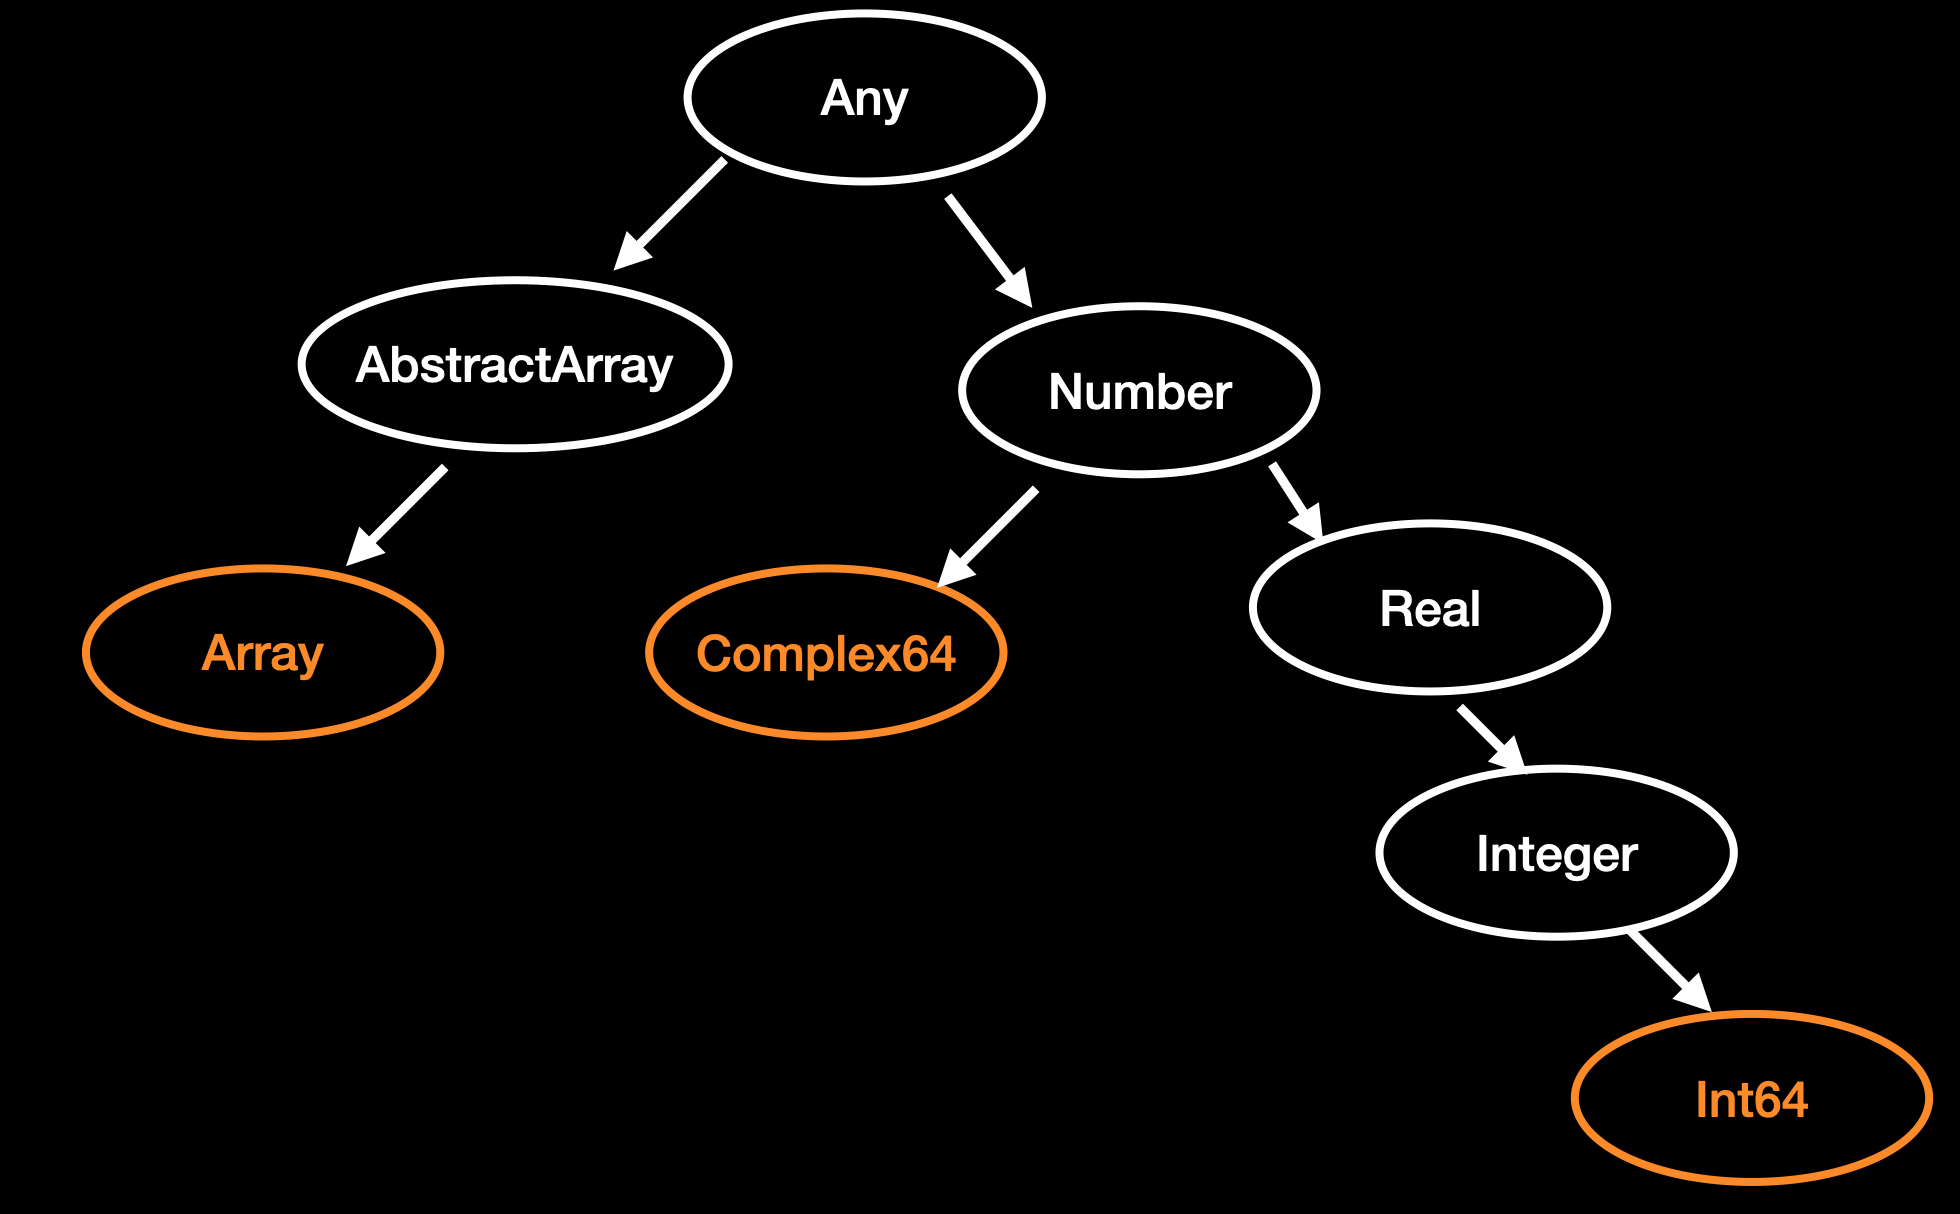

## 1.3. 可变类型 (mutable type)

默认情况下，Julia 结构体类型是不能被修改的 (immutable)

In [18]:
p = Point2D(1, 3)
p.x = 0

LoadError: setfield! immutable struct of type Point2D cannot be changed

如果需要修改的话，可以手动加上 `mutable` 关键字

In [19]:
mutable struct MPoint2D
    x::Float64
    y::Float64
end

In [20]:
p = MPoint2D(2.0, 1.0)
p.x = 0
p

MPoint2D(0.0, 1.0)

注：为了保证正确性，可变的数据不能直接存放在寄存器和栈中，所以 mutable 会让让代码的性能变得更慢. 后面会更具体介绍这一点.

## 1.4. 参数化类型

让我们的 `Point` 类型中的 `x`, `y` 固定使用 `Float64` 也许能够满足需求，但很自然的一个想法是：能否引入参数化/模版的概念，来允许更多的类型可能性？ Julia 通过 `{}` 语法提供了这样一种模式

In [21]:
struct Point{T<:Real} <: AbstractPoint
    x::T
    y::T
    
    function Point{T}(x::T, y::T) where T <: Real
        new{T}(x, y)
    end
    function Point(x::T, y::T) where T <: Real
        Point{T}(x, y)
    end
end

In [22]:
Point(1.0, 2.0)

Point{Float64}(1.0, 2.0)

In [23]:
Point{Float64}(1.0, 2.0)

Point{Float64}(1.0, 2.0)

In [24]:
p_f64 = Point(1.0, 2.0)

Point{Float64}(1.0, 2.0)

In [25]:
p_i64 = Point(1, 2)

Point{Int64}(1, 2)

要注意的是：他们是不一样的类型，所以他们的结果也并不一样

In [26]:
@show typeof(p_f64) == typeof(p_i64)
@show p_f64 == p_i64
nothing # 因为@show已经打印了结果，所以这里用来抑制 REPL 重复的打印

typeof(p_f64) == typeof(p_i64) = false
p_f64 == p_i64 = false


当然需要的情况下，可以通过多重派发来修改默认的等号定义

In [27]:
Base.:(==)(p_f64, p_i64) # 所有的运算符都是函数

false

这里我们只想要覆盖 `Point` 类型的等号定义，所以需要在方法的参数上写明类型

In [28]:
Base.:(==)(p::Point, q::Point) = p.x == q.x && p.y == q.y

In [29]:
p_f64 == p_i64 # 🎉

true

## 1.5. functor
functor 指的是像函数一样工作的类型

In [30]:
my_clamp(x, lo, hi) = x < lo ? lo : x > hi ? hi : x

my_clamp (generic function with 1 method)

In [31]:
my_clamp.(-0.5:0.3:1.5, 0.0, 1.0)

7-element Vector{Float64}:
 0.0
 0.0
 0.1
 0.4
 0.7
 1.0
 1.0

这件事情有时候会写成

In [32]:
struct Clamp{T}
    lo::T
    hi::T
end
# 定义了 Clamp 类型的实例作为函数使用。等价于 Python 中的 __call__ 方法
(f::Clamp)(x) = x < f.lo ? f.lo : x > f.hi ? f.hi : x

In [33]:
f = Clamp(0.0, 1.0)
f.(-0.5:0.3:1.5) # Clamp 类型的值作为函数使用

7-element Vector{Float64}:
 0.0
 0.0
 0.1
 0.4
 0.7
 1.0
 1.0

## 1.6. 方法 (method)

一个函数允许定义多个不同的方法，关于方法定义的最基本规则是：

* Rule 1: 函数调用时调用类型“最具体”的方法
* Rule 2: 存在多个匹配并且无法判断的时候直接报错
* Rule 3: 关键词参数不参与多重派发

In [34]:
g(x) = "Any"
g(x::String) = "String"

g (generic function with 2 methods)

In [35]:
g("hello")

"String"

In [36]:
h(x, y) = "h(x::Any, y::Any) is called"
h(x, y::Number) = "h(x::Any, y::Number) is called"
h(x::Number, y) = "h(x::Number, y::Any) is called"

h (generic function with 3 methods)

In [37]:
h(1, 1.0)

LoadError: MethodError: h(::Int64, ::Float64) is ambiguous. Candidates:
  h(x, y::Number) in Main at In[36]:2
  h(x::Number, y) in Main at In[36]:3
Possible fix, define
  h(::[0mNumber, ::[0mNumber)

出现歧义的时候，一般可以通过补充定义的方式来辅助 Julia 的类型系统

In [38]:
h(x::Number, y::Number) = "h(x::Number, y::Number) is called"

h (generic function with 4 methods)

In [39]:
h(1, 1.0)

"h(x::Number, y::Number) is called"

方法也有所谓的参数化方法

In [40]:
function mysum(A::AbstractArray{T}) where T<:Number
    rst = zero(T)
    for x in A
        rst += x
    end
    return rst
end

mysum (generic function with 1 method)

当不需要知道具体的参数值的时候，也可以省略它. 这与上面的写法是等价的

In [41]:
function mysum(A::AbstractArray{<:Number})
    rst = zero(eltype(A))
    for x in A
        rst += x
    end
    return rst
end

mysum (generic function with 1 method)

# 2. 典型设计模式

这些典型设计模式在 Julia 标准库中随处可见。它们背后的核心思路是：

- 如何设计更一般化的代码：优雅地设计代码来支持不同的使用（而不是复制黏贴）
- 如何达到最佳性能

大纲：

- 代码设计：
  - trait function 的设计：`ndims`, `eltype` 等
  - 带默认值的位置参数（多重派发版本）：`zeros`, `ones`, `rand` 等
  - trait-based dispatch
  - iterated dispatch
- 性能:
  - 类型稳定
  - 抽象类型
  - 可变类型

## 2.1. 代码设计

### 2.1.1. Trait function

`eltype`, `typeof`, `ndims` 等用来提取一些基本信息的函数在 Julia 下一般叫 trait function 或者 traits

`typeof`

In [42]:
typeof(1)

Int64

In [43]:
my_typeof(::T) where T = T

my_typeof (generic function with 1 method)

In [44]:
my_typeof(1)

Int64

Julia 关于数组的接口是如下定义的

```julia
abstract type AbstractArray{T,N} end
```

其中 `T` 为元素类型，`N` 为维数.

`eltype`

In [45]:
eltype([1, 2, 3])

Int64

In [46]:
my_eltype(::AbstractArray{T}) where T = T

my_eltype (generic function with 1 method)

In [47]:
my_eltype([1, 2, 3])

Int64

`ndims`

In [48]:
my_ndims(::AbstractArray{T,N}) where {T,N} = N

my_ndims (generic function with 1 method)

In [49]:
my_ndims(rand(4, 4))

2

In [50]:
X = rand(4, 4)
@btime my_ndims($X)

  0.038 ns (0 allocations: 0 bytes)


2

### 2.1.2 带默认值的位置参数 - 基于多重派发

`zeros` 的文档中的签名描述如下：

```julia
    zeros([T=Float64,] dims::Tuple)
```

其中 `T` 是可选位置参数

In [51]:
zeros((2, 3))

2×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [52]:
zeros(Float32, (2, 3))

2×3 Matrix{Float32}:
 0.0  0.0  0.0
 0.0  0.0  0.0

Julia 的函数定义中，带默认值的位置参数一定要放在最后。例如以下写法是错误的：

In [53]:
function my_zeros(T=Float64, dims::Tuple)
    out = Array{T,length(dims)}(undef, dims)
    fill!(out, zero(T))
end

LoadError: syntax: optional positional arguments must occur at end around In[53]:1

但是可以拆分成两个方法

In [54]:
my_zeros(dims) = my_zeros(Float64, dims)
function my_zeros(::Type{T}, dims::Tuple) where T
    out = Array{T,length(dims)}(undef, dims)
    fill!(out, zero(T))
end

my_zeros (generic function with 2 methods)

In [55]:
my_zeros((2, 3))

2×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [56]:
my_zeros(Float32, (2, 3))

2×3 Matrix{Float32}:
 0.0  0.0  0.0
 0.0  0.0  0.0

从而绕过了关于位置参数默认值的这一限制

### 2.1.3. Trait-based dispatch

这个方法的思路是构造一个空的数据类型来辅助 Julia 进行多重派发。这个方法有时又称为 Holy-trait （因为发明者叫 [tim holy](https://github.com/timholy)）

Motivation: 因为 Julia 不允许一个跨越抽象类型的继承，换句话说，当 `B` 和 `C` 之间不存在继承关系时，不允许定义 `A <: B` 且 `A <: C`。例如：企鹅是鸟类但企鹅不会飞这件事情并不能直接写

```julia
abstract type Flyable end
abstract type NotFlyable end

abstract type Animal end
abstract type Bird <: Animal end

# 这在其他语言下属于多重继承
struct Penguin <: {Flyable, Bird}
    name
end
```

在 Julia 下，可以通过构造 trait type 来实现

In [57]:
struct Flyable end
struct NotFlyable end
abstract type Animal end
abstract type Bird <: Animal end

struct Parrot <: Bird
    name
end
struct Penguin <: Bird
    name
end

is_flyable(x::Penguin) = NotFlyable()
is_flyable(x::Bird) = Flyable()

fly(x) = fly(is_flyable(x), x)
fly(::Flyable, x) = "$(x.name) flys"
fly(::NotFlyable, x) = "$(x.name) can't fly"

fly (generic function with 3 methods)

In [58]:
fly(Penguin("Jane"))

"Jane can't fly"

In [59]:
fly(Parrot("Doe"))

"Doe flys"

这在某些场景下非常有用，例如在矩阵的下标计算这件事情上，存在不同的索引方式:

- 有些矩阵类型支持线性下标索引
- 有些矩阵类型仅支持多重下标索引 (CartesianIndex)

这里面有几个关键点：

- 线性下标索引允许更高效的内存操作
- 我们不能在代码运行的时候才通过 `if` 来检查给定的矩阵类型是否支持线性下标索引，因为这会浪费很多计算量，并且也很容易导致编译器无法给出高效的代码优化（例如 SIMD）

注：当然，从一个用户的角度来说，绝大部分时候你并不需要亲自去思考这些特别基础的东西。但是如果想要进一步提升编程的认知并且成为一个开发者的话，则是需要了解这些的。

In [67]:
X = rand(3)
Y = rand(3, 3)' # 转置矩阵

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.727683  0.618231  0.616776
 0.674304  0.302966  0.784589
 0.29834   0.516675  0.371359

In [68]:
IndexStyle(X), IndexStyle(Y)

(IndexLinear(), IndexCartesian())

In [69]:
first(eachindex(X)), first(eachindex(Y))

(1, CartesianIndex(1, 1))

这里 `eachindex` 的构造方式就和 `fly` 类似：

```julia
struct IndexCartesian end
struct IndexLinear end

eachindex(X) = eachindex(IndexType(X), X)
eachindex(::IndexCartesian, X) = CartesianIndices(X)
eachindex(::IndexLinear, X) = LinearIndices(X)
```

### 2.1.4. 正交化代码设计

一个设计的好的多重派发可以写的很短并且避免各种歧义的产生，在设计多重派发的时候，一般来说会将代码设计正交化，这样做有两个好处：

- 减少代码冗余
- 避免多重派发的歧义

关于正交化代码设计最典型的场景是本质上为标量运算的矩阵函数，例如 `+`

```julia
# 第一步将矩阵运算直接拆分成标量运算
+(a::Matrix, b::Matrix) = map(+, a, b)
# 第二步将标量运算的数据类型转换成一致的
+(a, b) = +(promote(a, b)...)
# 最后才调用核心计算方法
+(a::Float64, b::Float64) = Core.add(a, b)
```

## 2.2. 关于性能

不考虑算法层面的问题的话，在 Julia 下想要得到好的性能的核心思路就是：传递更多的类型信息给编译器

In [70]:
function my_sum(X)
    rst = zero(eltype(X))
    @inbounds @simd for x in X
        rst += x
    end
    return rst
end

my_sum (generic function with 1 method)

### 2.2.1 类型稳定

In [71]:
if rand() > 0.5
    rand(Int)
else
    rand(Float64)
end

0.851217969715389

In [72]:
@code_warntype rand_unstable()

LoadError: UndefVarError: rand_unstable not defined

In [73]:
rand_unstable() = rand() > 0.5 ? rand(Int) : rand(Float64)
rand_stable() = rand() > 0.5 ? rand(Float64): rand(Float64)

X = @btime [rand_unstable() for _ in 1:1001]
@btime my_sum($X)

Y = @btime [rand_stable() for _ in 1:1001]
@btime my_sum($Y)

LoadError: syntax: space required before colon in "?" expression

## 2.2.2 抽象类型

In [74]:
struct MyNumber <: Real
    x
end
Base.:(+)(a::MyNumber, b::MyNumber) = MyNumber(a.x + b.x)
Base.zero(a::MyNumber) = MyNumber(0)

struct MyNumberT{T} <: Real
    x::T
end
Base.:(+)(a::MyNumberT, b::MyNumberT) = MyNumberT(a.x + b.x)
Base.zero(a::MyNumberT{T}) where T = MyNumberT(zero(T))

这两个类型表面上没有任何差别：他们都能存储任意的类型。但是差别在于前者传递给 Julia 编译器的类型信息是 Any 而后者是一个具体的模版类型 T

In [75]:
X = @btime [MyNumber(rand()) for _ in 1:1001]
@btime my_sum($X)

Y = @btime [MyNumberT(rand()) for _ in 1:1001]
@btime my_sum($Y)

  6.726 μs (1002 allocations: 23.64 KiB)
  111.353 μs (3003 allocations: 46.92 KiB)
  2.811 μs (1 allocation: 8.00 KiB)
  60.471 ns (0 allocations: 0 bytes)


MyNumberT{Float64}(497.7013685381756)

### 2.2.3 可变类型

可变这件事情会让编译器放弃一些优化策略，因此从性能的角度来说，很多时候我们需要使用不可变的数据结构

In [76]:
mutable struct MNumber{T} <: Real
   x::T
end
Base.:(+)(a::MNumber, b::MNumber) = MNumber(a.x + b.x)
Base.zero(a::MNumber) = MNumber(0)

In [77]:
X = @btime [MNumber(rand()) for _ in 1:1001]
@btime my_sum($X)

Y = @btime [MyNumberT(rand()) for _ in 1:1001]
@btime my_sum($Y)

  7.382 μs (1002 allocations: 23.64 KiB)
  3.667 μs (1002 allocations: 15.66 KiB)
  3.052 μs (1 allocation: 8.00 KiB)
  61.745 ns (0 allocations: 0 bytes)


MyNumberT{Float64}(478.92337658477805)

当然要注意的是，一个不可变的数据在某种意义上依然可以做到可变的（只要依然还是同一个对象）

In [78]:
struct Data{AT<:AbstractArray}
    data::AT
end

In [79]:
X = Data(rand(4, 4))

Data{Matrix{Float64}}([0.09001197287653917 0.16745869469938102 0.4887072681371949 0.8092234313083664; 0.4349864912709671 0.7100796276819663 0.40219492834551973 0.8346028431216066; 0.001760367400819307 0.11906747146564545 0.012824490964280066 0.18833065480288336; 0.8250581334897422 0.49371484585640624 0.07757687757373244 0.5526427594134511])

可以修改 `X.data` 的值

In [80]:
fill!(X.data, 0)
X

Data{Matrix{Float64}}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])

但是不能修改 `x.data`

In [81]:
X.data = rand(4, 4)

LoadError: setfield! immutable struct of type Data cannot be changed